#Kaggle Transfer Learning Code for the City Square Feed Kaggle In-Class Competition

In [11]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
# Unzip All Files and Store them Local
!mkdir train_local
!unzip /content/drive/MyDrive/INFO558/applications-of-deep-learning-wustlfall-2021.zip -d train_local

In [3]:
%matplotlib inline

# Import General Libraries
import os
import cv2
import pandas as pd
import numpy as np
import pickle
import keras
import tensorflow as tf

from matplotlib import pyplot as plt

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from keras.models import *
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.metrics import RootMeanSquaredError

import keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array

from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.models import Model

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold

## Generate Dataset

In [12]:
path = '/content/train_local/city/'

# Function to get train filenames, train labels, and train dataset (Not splitted yet)
def load_train(path):
  train_set = pd.read_csv('/content/train_local/city/train.csv')
  train_label = np.array(train_set['sqft'])
  train_files = []
  for i in range(len(train_set)):
    train_files.append(path + str(int(train_set.iloc[i][0])) + '.jpg')
  train_set['id'] = train_files
  return train_files, train_set, train_label

train_files, train_set, train_label = load_train(path)

In [13]:
# Function to get test filenames and test dataset 
def load_test(path):
  test_set = pd.read_csv('/content/train_local/city/test.csv')
  test_id = test_set['id']
  test_files = []
  for i in range(len(test_set)):
    test_files.append(path + str(int(test_set.iloc[i][0])) + '.jpg')
  test_set['id'] = test_files
  return test_files, test_set, test_id

test_files, test_set, test_id = load_test(path)

test_set.head()

,id
0,/content/train_local/city/24000.jpg
1,/content/train_local/city/24001.jpg
2,/content/train_local/city/24002.jpg
3,/content/train_local/city/24003.jpg
4,/content/train_local/city/24004.jpg


## Clustering

Since the cities are taken from different angle, we tried to cluster pictures by their visual similarity. By doing so, we can ensure that train dataset contains pictures from all angles.

### Feature Extractor

In [ ]:
# We chose VGG16 as feature extractor
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
  img = load_img(file, target_size=(224,224))
  img = np.array(img)
  reshaped_img = img.reshape(1, 224, 224, 3)
  imgx = preprocess_input(reshaped_img)
  features = model.predict(imgx, use_multiprocessing=True)
  return features

553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
data = {}
# Store features 
for file in train_files:
    feat = extract_features(file,model)
    data[file] = feat

In [ ]:
# Transform features to fit PCA
feat = np.array(list(data.values()))
feat = feat.reshape(-1, 4096)

In [ ]:
# Fit and transform with PCA
pca = PCA(n_components=100, random_state=0)
pca.fit(feat)
x = pca.transform(feat)

### KMeans

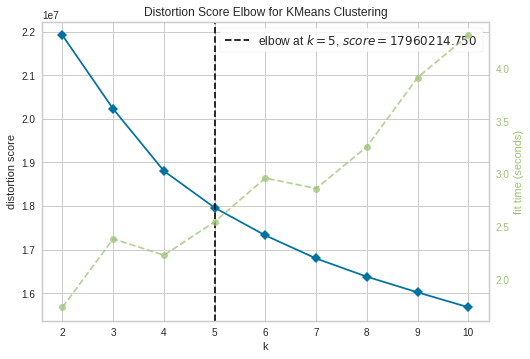

In [ ]:
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Find the best k
elbow_m = KElbowVisualizer(KMeans(), k=10)
elbow_m.fit(x)
elbow_m.show()

In [ ]:
# Fit K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(x)

KMeans(n_clusters=5, random_state=0)

In [ ]:
# Assign labels and output a csv file
train_set['cluster'] = kmeans.labels_
train_set.to_csv('/content/drive/MyDrive/INFO558/clustered_train.csv', index=False)

In [27]:
train_set.head()

,id,sqft,cluster
7956,/content/train_local/city/7957.jpg,3248,0
14237,/content/train_local/city/14238.jpg,6834,1
17342,/content/train_local/city/17343.jpg,4204,1
14863,/content/train_local/city/14864.jpg,3502,0
21417,/content/train_local/city/21418.jpg,4205,1


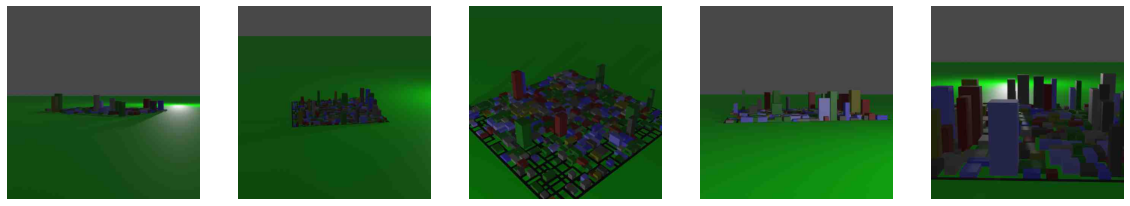

In [33]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

# show one image from each cluster
def showImages(list_of_files):
    fig = figure(figsize=(20,20))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')

images = ['/content/train_local/city/7957.jpg', '/content/train_local/city/14238.jpg',
          '/content/train_local/city/16719.jpg', '/content/train_local/city/877.jpg',
          '/content/train_local/city/12922.jpg']

showImages(images)

We wanted to train a model for each cluster, but we did not end up with this method. Therefore the following cell is optional.

In [ ]:
test = {}

for file in test_files:
    feat = extract_features(file,model)
    test[file] = feat

filenames = np.array(list(test.keys()))
testfeat = np.array(list(test.values()))
testfeat = testfeat.reshape(-1, 4096)
pca.fit(testfeat)
t = pca.transform(testfeat)

kmeans.fit(t)
test_set['cluster'] = kmeans.labels_
test_set.to_csv('/content/drive/MyDrive/INFO558/clustered_test.csv', index=False)

## Model

In [14]:
# Get the clustered dataset
train_set = pd.read_csv('/content/drive/MyDrive/INFO558/clustered_train.csv')
# test_set = pd.read_csv('/content/drive/MyDrive/INFO558/clustered_test.csv')

In [15]:
# Split dataset to train and validation set with 15% validation data. Stratify by cluster to ensure train data covers all angles.
train_set, val_set = train_test_split(train_set, test_size=0.15, random_state=0, stratify=train_set['cluster'])
valid_files = val_set['id']

In [16]:
# Define image dimension
img_height = 512
img_width = 512
img_channels = 3
img_size = (img_height, img_width)
img_dim = (img_height, img_width, img_channels)

# Train image preprocesser
training_datagen = ImageDataGenerator(
        rescale = 1./255, # rescale
        rotation_range=10, # rotation
        zoom_range=0.25, #zoom
        width_shift_range=0.2, # width shift
        height_shift_range=0.2, # height shift
        horizontal_flip=True, # hirozontal flip
        brightness_range=[0.8,1.2], # brightness
        fill_mode='nearest')

# Train image generator
train_generator = training_datagen.flow_from_dataframe(
        dataframe=train_set,
        directory=path,
        x_col="id",
        y_col="sqft",
        target_size=img_size,
        batch_size=8, # Keeping the training batch size small USUALLY increases performance
        class_mode='raw')

# Validation image preprocesser
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Validation image generator
val_generator = validation_datagen.flow_from_dataframe(
        dataframe=val_set,
        directory=path,
        x_col="id",
        y_col="sqft",
        target_size=img_size,
        batch_size=64, # Make the validation batch size as large as you have memory for
        class_mode='raw')

Found 20398 validated image filenames.
Found 3600 validated image filenames.


We tried several pre-trained models, such as EfficientNetB0 & B6, ResNet, VGG 16, VGG 19, InceptionV3 and MobileNet. They have their own advantages. For example, training EfficientNets is much more faster than other pre-trained models. Here we only show the model that gave us the best validation RMSE, which is Inception ResNet V2.

In [21]:
# We chose Inception ResNet V2 as our base model. 
def model(img_dim=img_dim):
    input_tensor = Input(shape=img_dim)
    base_model = InceptionResNetV2(include_top=False,
                   weights='imagenet', # Use pre-trained weight
                   input_shape=img_dim)
    # base_model.trainable=False
    bn = BatchNormalization()(input_tensor) # Batch normalization for preventing overfitting
    x = base_model(bn)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(512, (2, 2), activation='relu')(x)
    x = MaxPooling2D((1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x) # Dropout for preventing overfitting
    output = Dense(1, activation='relu')(x)
    model = Model(input_tensor, output)
    return model

model = model()
#model.summary()

219070464/219055592 [==============================] - 4s 0us/step


We also tried some ways to prevent overfitting. L2 regularization, LeakyReLU avtication, and Kaiming initialization.

In [ ]:
# Kaiming initialization ()
init_weight = tf.keras.initializers.HeNormal()

# Code for regularization and leakyReLU
#x=Dense(1024,kernel_initializer=init_weight,kernel_regularizer=regularizers.l2(1e-4))(x)
#x=LeakyReLU()(x)   # Prevent dying neurons

In [ ]:
# Compile model. MSE and RMSE for loss and metrics since this is a regression problem. Adam is chosen to be the optimizer.
model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=[RootMeanSquaredError(name="rmse")])

In [ ]:
# EarlyStoppling.
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, verbose=1, mode='auto',
        restore_best_weights=True)

# Checkpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/INFO558/checkpoint.h5', 
        monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min', verbose=1)

# Learning Rate Decay
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=0, mode='auto', 
        min_delta=10000, cooldown=0, min_lr=0)

history = model.fit(train_generator, epochs=200, steps_per_epoch=150, 
                    validation_data = val_generator, callbacks=[monitor,checkpoint,reduce_lr],
                    verbose = 1, validation_steps=STEP_SIZE_VALID)

### Evaluate Best Model

We don't have the training history for our best model. We saved it as h5 file and evaluate here.

In [4]:
model = tf.keras.models.load_model('/content/drive/MyDrive/INFO558/checkpoint.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 batch_normalization_203 (Ba  (None, 512, 512, 3)      12        
 tchNormalization)                                               
                                                                 
 inception_resnet_v2 (Functi  (None, 14, 14, 1536)     54336736  
 onal)                                                           
                                                                 
 conv2d_203 (Conv2D)         (None, 12, 12, 256)       3539200   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                             

In [17]:
model.evaluate(val_generator, verbose=1)

57/57 [==============================] - 66s 940ms/step - loss: 158207.5781 - rmse: 397.7531


[158207.578125, 397.7531433105469]

## Build Submission

In [ ]:
submit_datagen = ImageDataGenerator(rescale = 1./255)
submit_generator = submit_datagen.flow_from_dataframe(
    dataframe = test_set,
    directory = path,
    x_col = 'id',
    batch_size = 1,
    shuffle = False,
    target_size = img_size,
    class_mode = None
)

pred = model.predict(submit_generator, steps=len(test_set))

In [ ]:
test_set['sqft'] = pred
test_set['id'] = test_id
test_set.to_csv("submit.csv",index = False)